In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as plot_style
import sys
from pathlib import Path
print(str(Path.cwd().parent))
sys.path.append(str(Path.cwd().parent))
plot_style.use('plots.mplstyle')

/home/f/Dev/virtual_lab


In [2]:
from virtual_lab.experiments import *
from virtual_lab.simulation import *
from virtual_lab.model import *
from virtual_lab.utils import *
from examples.required_files.const import *
from examples.required_files.experiment_list import *
from examples.required_files.models import *
from virtual_lab.logger import *


In [3]:
# Initialize the simulation
Sim = Simulation()
Sim.save_figs = False

# DIAGNOSTIC is the highest level of logging. If you don't want to see logs, set to ERROR
VL_Logger.set_log_level(LogLevel.DIAGNOSTIC)

Set log level to DIAGNOSTIC


In [4]:
# Rich-text expressions for variables to be used in labels
# The keys are the actual variable names used in the code
variable_labels = {
    "Vpsd": r'$V_{PSD}$',
    "V_tot": r'$V_{tot}$',
    "Vd": r'$V_d$',
    "Vs": r'$V_s$',
    "V_eff": r'$V_{eff}$',
    "Ve": r'$V_m$', 
    "crosslink": 'cross.',
    "stim": "HFS"
}

# Define the EC model

In [5]:
# Constants are defined in the required_files/const.py file
const_base = CONSTANTS.copy()
gamma = const_base["gamma_0"]*const_base["g_mul_LTP"]
mu = const_base["mu_0"]*const_base["m_mul_LTP"]

In [6]:
early_consolidation = BaseModel("EC", {"Vd":None,"Vs":None,"Vpsd":1,"V_eff":None,"V_tot":None},const = const_base,
                                labels = variable_labels)

# These should be the standard values that were used for my thesis
# NOTE: This effectively overwrites the values defined in the CONSTANTS dictionary above! These are the ones
# that matter for this model. Parameters that are not present here are taken from their default values in const.py
early_consolidation.P_ONSET = 12.5 * 60
early_consolidation.nf_0 = 0.04
early_consolidation.nf_LTD = 0
early_consolidation.nf_LTP = 12
early_consolidation.tau_Vd = 2400
early_consolidation.k_u_0 = 1*20/3/(3600*2)
early_consolidation.k_b_0 = 1*1/3/(600*2)
early_consolidation.k_u_1 = 1000/3/3600
early_consolidation.k_b_1 = 1/3/600

# Plus some variant that I don't really remember
# early_consolidation.P_ONSET = 15 * 60
# early_consolidation.nf_0 = 0.04
# early_consolidation.nf_LTP = 15.2
# early_consolidation.tau_Vd = 8000

# The experiments depend on some of the values defined above. For a list of which ones influence the experiments,
# look at the required_files/experiment_list.py (lines 37-46 roughly, with the constants defined in CAPS-LOCK)
early_consolidation.experiments = create_experiments(early_consolidation)
Sim.add_model(early_consolidation,switching=True)

INFO simulation_1: Switching to model EC
DEBUG simulation_1: Saving user preferences to usr_prefs/user_prefs.json


# Simple ODE integration experiments

## Optimizer code

In [7]:
# The data extracted from the experimental data from Frey. It's used in the loss function "experiment_deviation", and 
# also for a plot later in the notebook.
STC_data = {
    "time_data":[5/60+0.25,1+0.25,2+0.25,4+0.25],
    "volume_data": [1.43,1.32,1.15,0.99],
    "err": [0.15,0.08,0.05,0.08]
}
k_b_k_u_ratio = 1/3

In [8]:
# WEIGHT = np.exp(-np.array(range(10)))
# print(WEIGHT)

In [9]:
# I have to say, my experiments with the Bayesian Optimization were not very fruitful, your 
# results proved much better. I leave this loss function here just in case there might be something
# useful in it..
from bayes_opt import BayesianOptimization, UtilityFunction

STC_exp = Experiments(
    [Experiment("STC 2 Hours",
                        {"stim": [[300,WTET]],
                        "LFS": [],
                        "crosslink": [[300, X_WTET]],
                        "protein" : [[int(p*60),int(p*60)+3600]] },dt = 1,T = 6*3600) for p in STC_data['time_data']])

def experiment_deviation():
    LTP = early_consolidation.experiments['Basic'].get_experiment("S_TET")
    LTP_results = Sim.run_experiments(LTP)

    exp_data = LTP.experimental_data['Matsuzaki 2004']
    exp_V_LTP = np.array(exp_data['y']) *LTP_results[0]["V_tot"][0]
    exp_t_LTP = np.array(exp_data['x']) *60
    selected_V = LTP_results[0]['V_tot'][exp_t_LTP.astype(int)]

    # For LTP the early phase is the most important
    WEIGHT = np.exp(-np.array(range(len(exp_V_LTP))))
    loss = sum(WEIGHT*((exp_V_LTP-selected_V)/selected_V)**2)

    LTD = early_consolidation.experiments['Basic'].get_experiment("LTD")
    LTD_results = Sim.run_experiments(LTD)

    exp_data = LTD.experimental_data['Kasai Noguchi 2015']
    exp_V_LTD = np.array(exp_data['y']) *LTD_results[0]["V_tot"][0]
    exp_t_LTD = np.array(exp_data['x']) *60
    selected_V = LTD_results[0]['V_tot'][exp_t_LTD.astype(int)]

    # For LTD the late phase is the most important
    WEIGHT = np.exp(-np.array(range(len(exp_V_LTD))))[::-1]*10
    loss += sum(WEIGHT*((exp_V_LTD-selected_V)/selected_V)**2)
    if any(LTD_results[0]['Vpsd']<0.05):
        loss += 1e6

    STC_results = Sim.run_experiments(STC_exp)

    vol_data = STC_data['volume_data']
    time_data = np.asarray(STC_data['time_data'])*60
    selected_Vpsd = []
    for k in range(len(time_data)):
        selected_Vpsd = STC_results[k]['Vpsd'][-1]
    # Here the weight is same for all points
    loss += sum(((vol_data-selected_Vpsd)/selected_Vpsd)**2)
    
    return - loss

def evaluate_params(**params):
    for key,value in params.items():
        setattr(early_consolidation,key,value)
    early_consolidation.experiments = create_experiments(early_consolidation)
    loss = experiment_deviation()
    return loss

# The optimizer is used in one of the cells below.


In [10]:
# params = optimizer.max['params']
# params['k_b_0'] = k_b_k_u_ratio*params['k_u_0']
# print(params)

### Values from Micha (comment if want own optimized values!)

In [11]:
# Parameters found from the optimization 
params_micha = {'nf_0': 0.00025, 'nf_LTD': 0.0, 'nf_LTP': 0.02, 'ratio_0': 3.787769967758817, 'ratio_1': 232.5023763795744, 'ratio_psd': 9.0, 'tau_Vd': 1503.2167264252723, 'tau_u_0': 3379.042736072486, 'tau_u_1': 30.0}

In [12]:
# Conversion to my version of the equations 
# (if you want to use the new equations you could try to modify the BaseModel equations at required_files/models.py)
params = params_micha.copy()
params['k_u_0'] = 1/params.pop('tau_u_0')
params['k_u_1'] = 1/params.pop('tau_u_1')

params['k_b_0'] = params['k_u_0'] / 3.8
params['k_b_1'] = params['k_u_1'] / (params.pop('ratio_1'))
params['tau_Vd'] = 4500
params['tau_PSD_mol'] = params['tau_Vd'] / 6.5
params['nu'] = 1
params['nf_LTP'] = 0.04

params.pop('ratio_psd')
print(params)


{'nf_0': 0.00025, 'nf_LTD': 0.0, 'nf_LTP': 0.04, 'ratio_0': 3.787769967758817, 'tau_Vd': 4500, 'k_u_0': 0.0002959418030806901, 'k_u_1': 0.03333333333333333, 'k_b_0': 7.78794218633395e-05, 'k_b_1': 0.00014336771026767753, 'tau_PSD_mol': 692.3076923076923, 'nu': 1}


In [13]:
# Allowing the parameters to change by 10% around your values (see below)
ranges = {}
relative_change = 0.1
for key,value in params.items():
    ranges[key] = (value-value*relative_change, value+value*relative_change)

In [14]:

# Here I tried to use BO to further optimize your values with my loss, but again, no big gain..

# optimizer = BayesianOptimization(
#     f = evaluate_params,
#     pbounds=ranges,
#     random_state=1)

# acquisition_function = UtilityFunction(kind="ucb", kappa=0.1)

# optimizer.maximize(init_points = 50, n_iter = 10, acquisition_function=acquisition_function)

## Set parameters

In [15]:
# params = optimizer.max['params']
# print(params)

In [16]:
# print(params['nf_LTP'])
# params['nf_LTP'] = 12

# Setting the parameters of the model
# NOTE that these parameters don't affect the experiments we generated before so we don't have to re-generate them.
for key,value in params.items():
    setattr(early_consolidation,key,value)
print(Sim.model.variables.Vpsd)

1


In [17]:
# Taken from the experiment_list.py (just a few representative ones that can display the behavior of the model)
exp_names = ["STC_LTP_WBS", "S_TET", "LTD","STC_LTD_WBS","LTP_X2","STC_TRLTD"]

INFO simulation_1: Simulating 1 experiments took: 0.057 s
INFO simulation_1: Plotting 1 experiments
DEBUG simulation_1: Saving user preferences to usr_prefs/user_prefs.json
DEBUG simulation_1: Plotting experimental quantities: ['crosslink', 'crosslink', 'protein', 'stim', 'LFS', 'cytochalasin', 'stim', 'LFS', 'stim', 'LFS', 'jaspl']
['stim', 'LFS', 'crosslink', 'protein']
DEBUG simulation_1: Saved plot figure in file: STC_LTP_WBS_EC.pdf


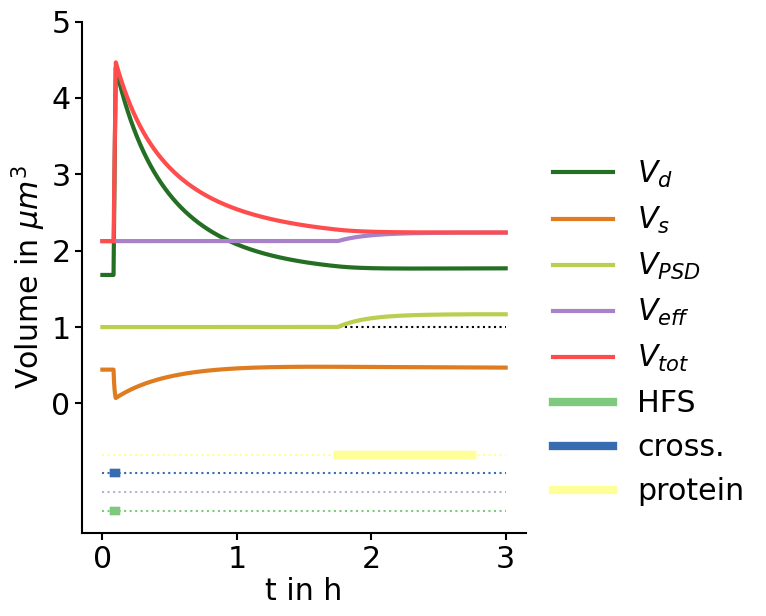

INFO simulation_1: Simulating 1 experiments took: 0.036 s
INFO simulation_1: Plotting 1 experiments
DEBUG simulation_1: Saving user preferences to usr_prefs/user_prefs.json
DEBUG simulation_1: Saving user preferences to usr_prefs/user_prefs.json
DEBUG simulation_1: Plotting experimental quantities: ['crosslink', 'crosslink', 'protein', 'stim', 'LFS', 'cytochalasin', 'stim', 'LFS', 'stim', 'LFS', 'jaspl']
['stim', 'LFS', 'crosslink', 'protein']
DEBUG simulation_1: Saved plot figure in file: S_TET_EC.pdf


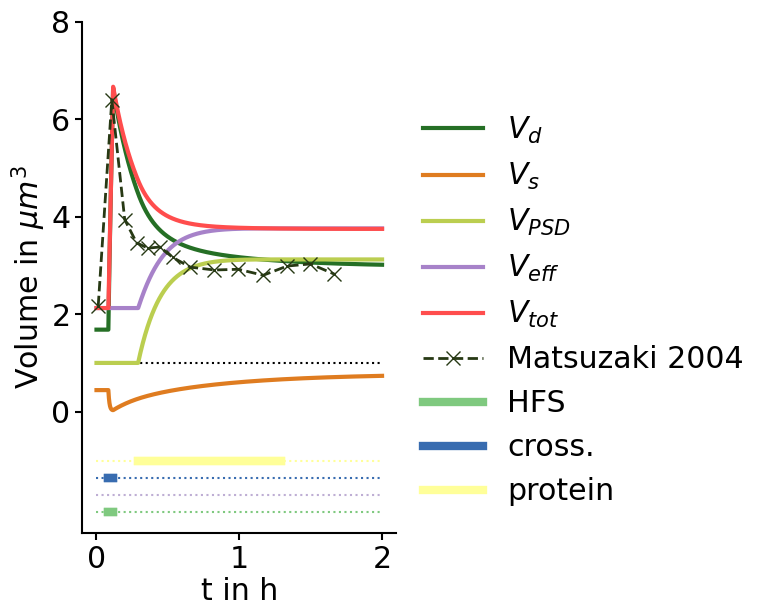

INFO simulation_1: Simulating 1 experiments took: 0.042 s
INFO simulation_1: Plotting 1 experiments
DEBUG simulation_1: Saving user preferences to usr_prefs/user_prefs.json
DEBUG simulation_1: Saving user preferences to usr_prefs/user_prefs.json
DEBUG simulation_1: Plotting experimental quantities: ['crosslink', 'crosslink', 'protein', 'stim', 'LFS', 'cytochalasin', 'stim', 'LFS', 'stim', 'LFS', 'jaspl']
['stim', 'LFS', 'crosslink', 'protein']
DEBUG simulation_1: Saved plot figure in file: LTD_EC.pdf


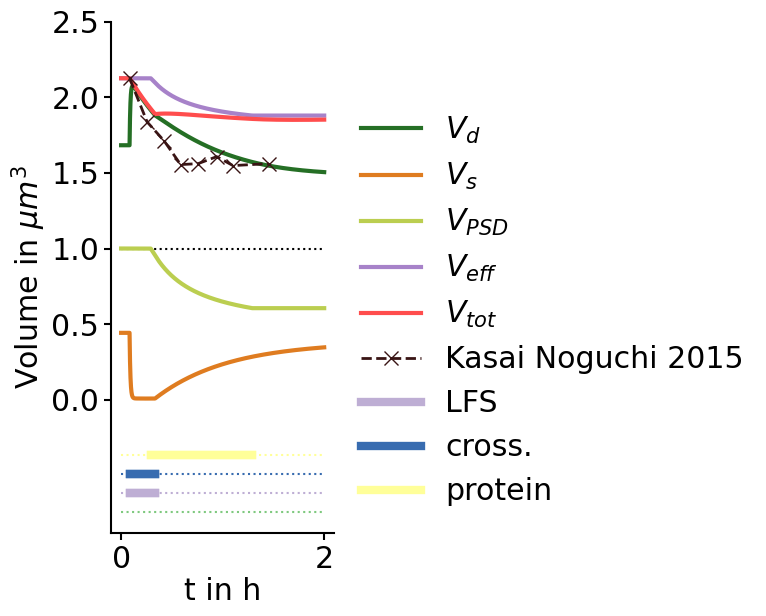

INFO simulation_1: Simulating 1 experiments took: 0.054 s
INFO simulation_1: Plotting 1 experiments
DEBUG simulation_1: Saving user preferences to usr_prefs/user_prefs.json
DEBUG simulation_1: Plotting experimental quantities: ['crosslink', 'crosslink', 'protein', 'stim', 'LFS', 'cytochalasin', 'stim', 'LFS', 'stim', 'LFS', 'jaspl']
['stim', 'LFS', 'crosslink', 'protein']
DEBUG simulation_1: Saved plot figure in file: STC_LTD_WBS_EC.pdf


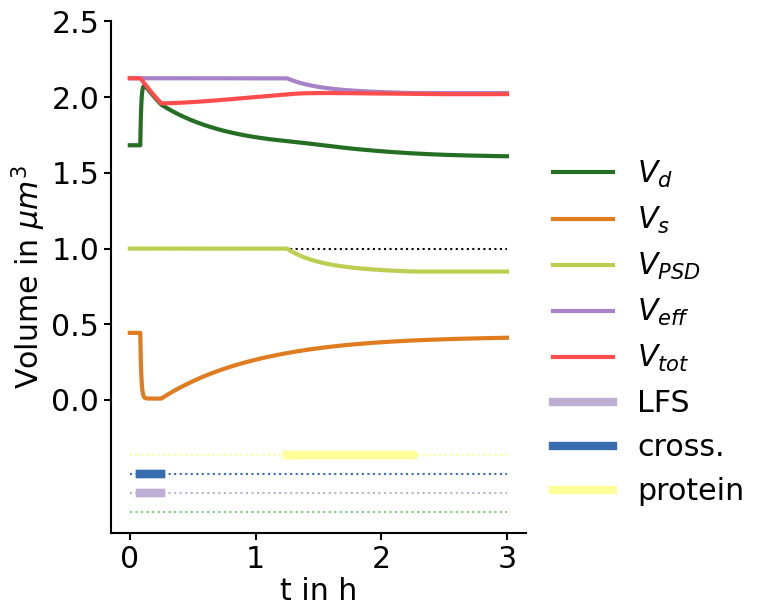

INFO simulation_1: Simulating 1 experiments took: 0.113 s
INFO simulation_1: Plotting 1 experiments
DEBUG simulation_1: Saving user preferences to usr_prefs/user_prefs.json
DEBUG simulation_1: Plotting experimental quantities: ['crosslink', 'crosslink', 'protein', 'stim', 'LFS', 'cytochalasin', 'stim', 'LFS', 'stim', 'LFS', 'jaspl']
['stim', 'LFS', 'crosslink', 'protein']
DEBUG simulation_1: Saved plot figure in file: LTP_X2_EC.pdf


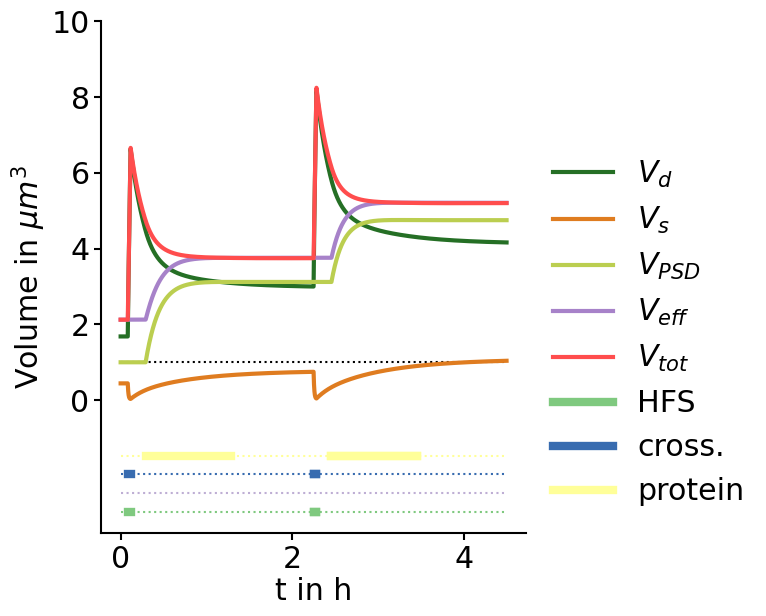

INFO simulation_1: Simulating 1 experiments took: 0.037 s
INFO simulation_1: Plotting 1 experiments
DEBUG simulation_1: Saving user preferences to usr_prefs/user_prefs.json
DEBUG simulation_1: Plotting experimental quantities: ['crosslink', 'crosslink', 'protein', 'stim', 'LFS', 'cytochalasin', 'stim', 'LFS', 'stim', 'LFS', 'jaspl']
['stim', 'LFS', 'crosslink', 'protein']
DEBUG simulation_1: Saved plot figure in file: STC_TRLTD_EC.pdf


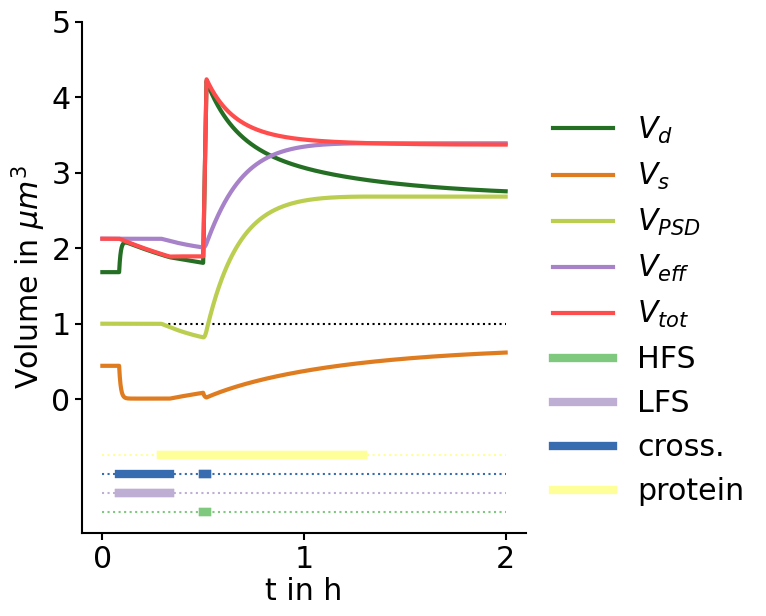

In [18]:
# Not really needed, but just to make sure we're using the right model
Sim.switch_model("EC")
experiments = []
for exp_name in exp_names:
    exp = early_consolidation.experiments["Basic"].get_experiment(exp_name)
    # If you want to get the results and do your own plotting, use the output of this function 
    # (a list of results, in this case of length one since we only run one at a time)
    _ = Sim.run_experiments(exp, stochastic=False)  
    Sim.plot_results(filename = f"{exp_name}_EC.pdf", time_unit = 'h',
    fontsize = 18, use_title = False, legend = True)
    
    # Other keywords: 
    # separate_legend(bool), plot the legend as a separate plot, to keep the images cleaner. If you save this plot, the legend will also be saved separately as filename_legend.ext (same extension as file)
    # variables(list[str] of variables to plot, if not given plots all), 
    # time_interval([int,int] limit the plot to this interval (not always pretty but can be useful))
    # filename(str) name of the file to save this plot to, by default they are saved in the plots folder (should be created dynamically when you save the first plot)                                              

# Protein availability experiments

## LTP

In [19]:
# Playing around with protein durations to see their effect on distance from the stimulus
import numpy as np
short = True
LTP_results = {}
# We will use these "short" and "long" labels to see long and short protein availabilities
protein_duration = {
    "short": 3600,
    "long": 3*3600
}
# The protein onset is varied from way before to way after the stimulus onset (typically at time 300)
protein_times = {
    label: [[max(k-p_d,0),min(k,p_d)] for k in np.arange(100,6*3600+p_d,300)] for label,p_d in protein_duration.items()
} # protein_times = {'short':[[-A_LOT, 100],[...]], "long":[[-MUCH_MORE,100],...]}

# Define the x-axis for the plots to come (we center 0 as the time of the stimulus, that's why we have 300 here and there)
x_data = {
    label: (np.arange(100,6*3600+protein_duration[label],300) - protein_duration[label] - 300)/3600 for label in protein_duration
}

In [20]:
# Create the actual experiments for the thing described above
for label in ["short","long"]:
    p_d = protein_duration[label]
    ProteinTimeLTP = Experiments(
        [
            Experiment("Protein availability LTP",
                        {"stim": [[300,WTET]],
                        "LFS": [],
                        "crosslink": [[300, X_WTET]],
                        "protein" : [p] },dt = 5,T = 8*3600) for p in protein_times[label]
        ]
    )
    LTP_results[label] = Sim.run_experiments(ProteinTimeLTP)

INFO simulation_1: Simulating 84 experiments took: 2.712 s
INFO simulation_1: Simulating 108 experiments took: 3.149 s


In [21]:
# Sim.plot_results([LTP_results['short'][0]],time_interval=[0,100]) # Just plotting one of the experiments to see if everything looks okay

INFO simulation_1: Making 1 plots
DEBUG simulation_1: Figsize (8, 6.5)


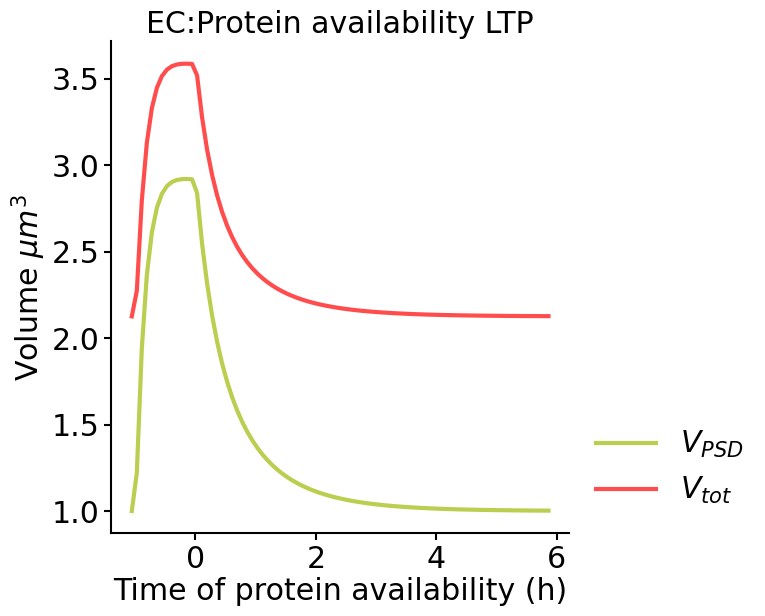

INFO simulation_1: Making 1 plots
DEBUG simulation_1: Figsize (8, 6.5)


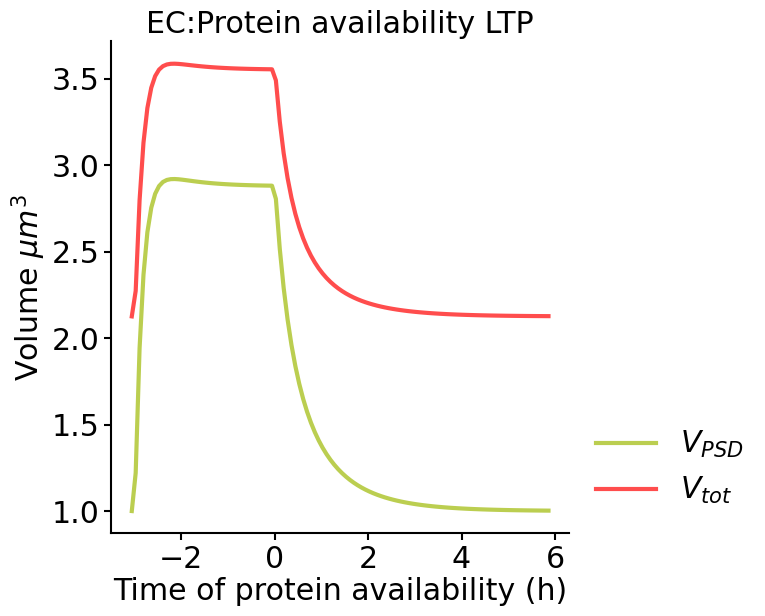

In [22]:
LTP_data = {}
for label in ['short','long']:
    # The plot_selected_points function selects a certain point across different experiments-results and plots them (the order of the experiments is important!)
    # Here the point selected is "last", meaning the last timestep of each experiment is chosen.
    LTP_data[label] = Sim.plot_selected_points(LTP_results[label],["Vpsd","V_tot"],"last",["stim"], x_data= x_data[label], xlabel = "Time of protein availability (h)",
    ylabel = r"Volume $\mu m^3$", filename = f"LTP_{label}_protein_times_EC.pdf", separate_legend = False, fontsize = 18, return_data = True)

<>:8: SyntaxWarning: invalid escape sequence '\&'
<>:8: SyntaxWarning: invalid escape sequence '\&'
/tmp/ipykernel_100472/462060224.py:8: SyntaxWarning: invalid escape sequence '\&'
  label = 'Frey \& Morris, 1998')


<ErrorbarContainer object of 3 artists>

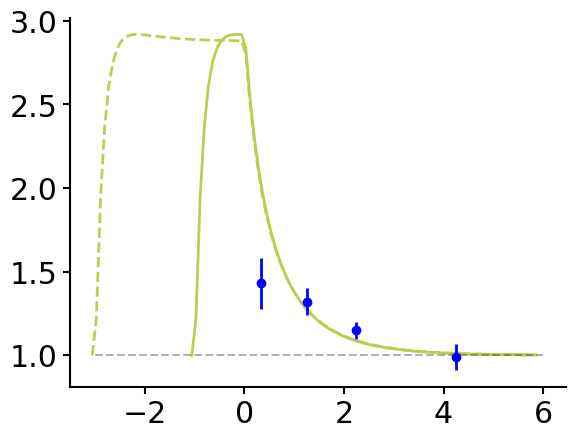

In [23]:
# Comparison with the STC data from Frey & Morris provided
for label in ['short','long']:
    style = '-' if label == 'short' else '--'
    time = '1h' if label == 'short' else '3h'
    plt.plot(x_data[label], LTP_data[label]['Vpsd'], linestyle = style, linewidth = 2, color = Sim.color_coding['Vpsd'], label = f"LTP, {time}")
plt.plot([-3,6],[1,1],color = 'k',alpha = 0.3,linestyle = '--')
plt.errorbar(STC_data['time_data'],STC_data['volume_data'],yerr=STC_data['err'], linestyle = '', linewidth = 2, marker = '.',markersize = 12, color = 'b',
             label = 'Frey \& Morris, 1998')

## LTD

In [24]:
LTD_results = {}
LTD_data = {}

In [25]:
# Exactly the same as above but for LTD
for label in ['short','long']:
    WLFS = Sim.model.WLFS
    ProteinTimeLTD = Experiments(
        [
            Experiment("Protein availability LTD",
                        {"stim": [],
                        "LFS": [[300,WLFS]],
                        "crosslink": [[300, X_WTET]],
                        "protein" : [p] },dt = 5,T = 8*3600) for p in protein_times[label]
        ]
    )
    LTD_results[label] = Sim.run_experiments(ProteinTimeLTD)

INFO simulation_1: Simulating 84 experiments took: 2.699 s
INFO simulation_1: Simulating 108 experiments took: 3.153 s


INFO simulation_1: Plotting 1 experiments
DEBUG simulation_1: Saving user preferences to usr_prefs/user_prefs.json
DEBUG simulation_1: Plotting experimental quantities: ['crosslink', 'crosslink', 'protein', 'stim', 'LFS', 'cytochalasin', 'stim', 'LFS', 'stim', 'LFS', 'jaspl']
['stim', 'LFS', 'crosslink', 'protein']
DEBUG simulation_1: Saved plot figure in file: img.pdf


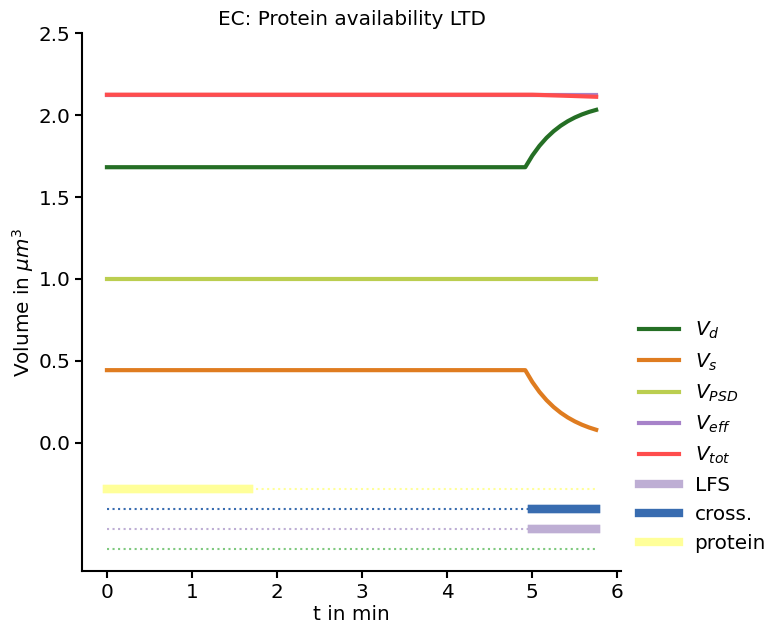

In [26]:
Sim.plot_results([LTD_results['short'][0]],time_interval=[0,350]) # Again just to check if the behaviour looks right

INFO simulation_1: Making 1 plots
DEBUG simulation_1: Figsize (8, 6.5)


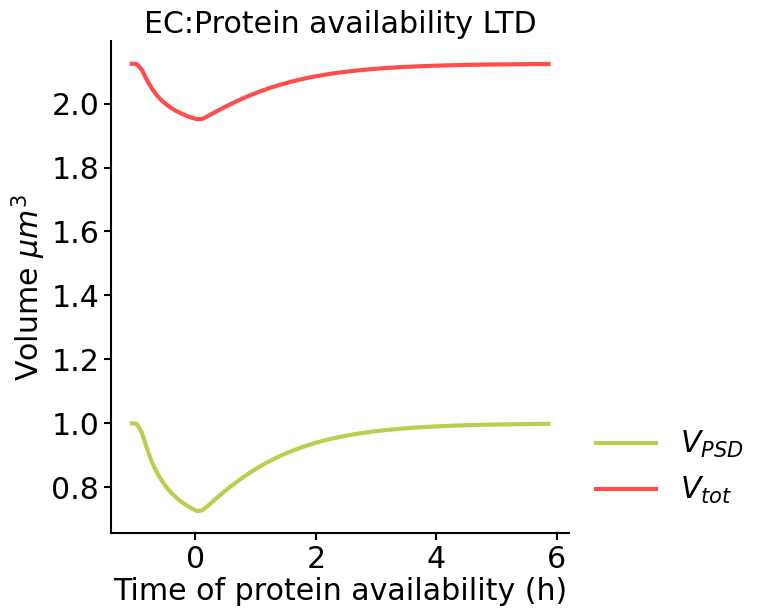

INFO simulation_1: Making 1 plots
DEBUG simulation_1: Figsize (8, 6.5)


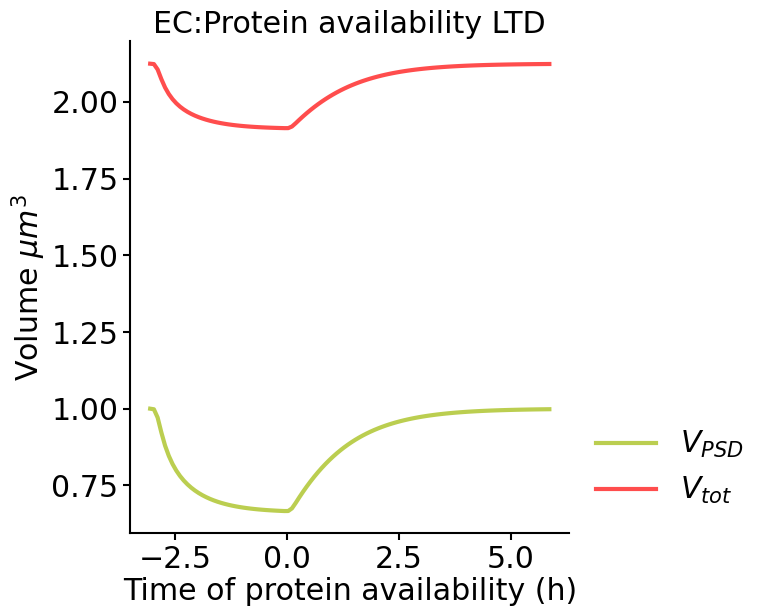

In [27]:
for label in ['short','long']:
    LTD_data[label] = Sim.plot_selected_points(LTD_results[label],["Vpsd","V_tot"],"last",["stim"], x_data= x_data[label],xlabel = "Time of protein availability (h)",
    ylabel = r"Volume $\mu m^3$", filename = f"LTD_{label}_protein_times_EC.pdf", separate_legend = False, fontsize = 18, return_data = True)

# Composite plot

<>:10: SyntaxWarning: invalid escape sequence '\&'
<>:10: SyntaxWarning: invalid escape sequence '\&'
/tmp/ipykernel_100472/4179139647.py:10: SyntaxWarning: invalid escape sequence '\&'
  label = 'Frey \& Morris, 1998')


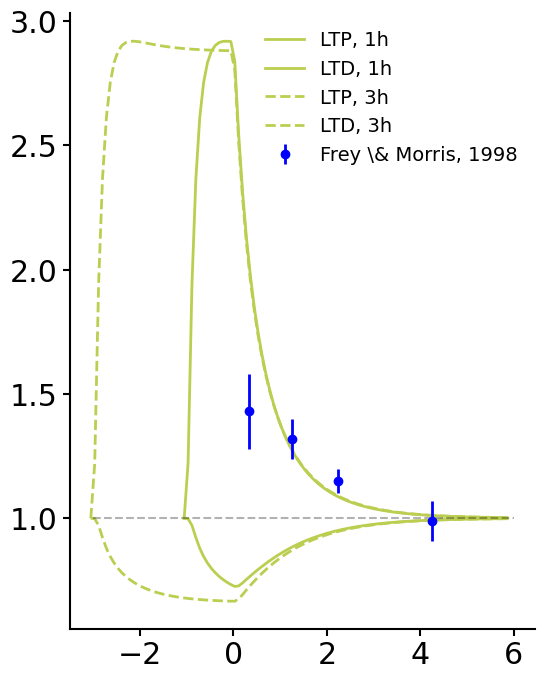

In [28]:
# Composite plot for LTD and LTP (no data for LTD to compare with)
plt.figure(figsize=(6,8))
for label in ['short','long']:
    style = '-' if label == 'short' else '--'
    time = '1h' if label == 'short' else '3h'
    plt.plot(x_data[label], LTP_data[label]['Vpsd'], linestyle = style, linewidth = 2, color = Sim.color_coding['Vpsd'], label = f"LTP, {time}")
    plt.plot(x_data[label],LTD_data[label]['Vpsd'], linestyle = style,  linewidth = 2, color = Sim.color_coding['Vpsd'], label = f"LTD, {time}")
plt.plot([-3,6],[1,1],color = 'k',alpha = 0.3,linestyle = '--')
plt.errorbar(STC_data['time_data'],STC_data['volume_data'],yerr=STC_data['err'], linestyle = '', linewidth = 2, marker = '.',markersize = 12, color = 'b',
             label = 'Frey \& Morris, 1998')
# plt.ylim((0.5,2.1))
legend = plt.legend(loc = 'upper right',fontsize = 14)
plt.savefig("plots/protein_availability.pdf")

## LTP Spacing experiments

INFO simulation_1: Simulating 61 experiments took: 1.632 s
INFO simulation_1: Simulating 1 experiments took: 0.026 s
INFO simulation_1: Making 1 plots
DEBUG simulation_1: Figsize (8, 6.5)


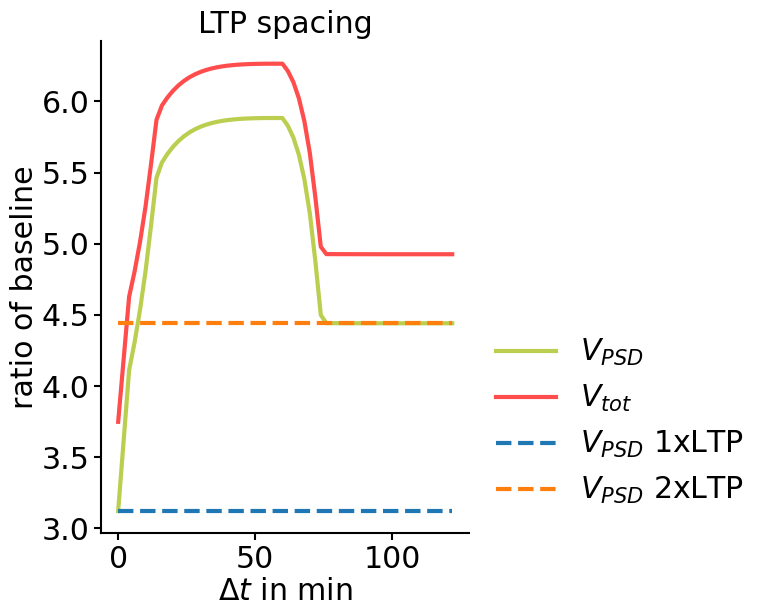

In [29]:
# You can play around with these values
protein_duration = 1*3600
inter_step = int(protein_duration/3600*2)*60
last_stim = protein_duration+3600
label = 'short' if protein_duration < 3601 else 'long'
P_ONSET = 15*60
# Create a list of experiments in which we increase the spacing between two STET programmatically 
LTP_SPACING = Experiments([Experiment(f"LTPx2_{int(t/60)}",
            {"stim": [[300,STET],[300+STET + t,STET]],
            "LFS": [],
            "crosslink": [[300,X_STET],[300+STET + t,X_STET]],
            "protein": [[300+P_ONSET, protein_duration],[300 + t + STET + P_ONSET,protein_duration]]},
            T = 7*3600,dt = 5) for t in np.arange(120,last_stim+inter_step,inter_step)])
LTP_SPACING.add(Sim.model.experiments['Basic'].get_experiment("S_TET"),idx = 0)
# Baseline for 2 fully developed LTPs
LTP_X2 = Experiment("LTP_X2",
                        {"stim": [[300, STET],[last_stim, STET]], 
                        "LFS": [], 
                        "crosslink": [[300, X_STET],[last_stim, X_STET]], 
                        "protein" : [[300+P_ONSET, protein_duration],[last_stim+P_ONSET, protein_duration]] }, T = 7*3600, dt = 5)

spacing = Sim.run_experiments(LTP_SPACING)
ltp2 = Sim.run_experiments(LTP_X2)
x_data = [exp.stim[1][1]-300-STET for exp in LTP_SPACING.experiments[1:]]
x_data.insert(0,0)
x_data = np.array(x_data)/60

reference_values = [spacing[0]["Vpsd"][-1],ltp2[0]["Vpsd"][-1]]
reference_labels = [r"$V_{PSD}$ 1xLTP", r"$V_{PSD}$ 2xLTP"]
Sim.plot_selected_points(spacing,["Vpsd","V_tot"],"last",x_data=x_data, fontsize = 18,
                        reference_values = reference_values, ref_labels = reference_labels, filename=f"LTP-spacing-{label}-protein.pdf",
                        xlabel = r'$\Delta t$ in min', use_legend = True, separate_legend = False, title = "LTP spacing")

In [30]:
print(spacing[-1]['Vpsd'][-1],ltp2[-1]['Vpsd'][-1]) # Just checking that the system settles in the same configuration

4.440875600441446 4.440808582122471


INFO simulation_1: Plotting 2 experiments
DEBUG simulation_1: Saving user preferences to usr_prefs/user_prefs.json
DEBUG simulation_1: Plotting experimental quantities: ['crosslink', 'crosslink', 'protein', 'stim', 'LFS', 'cytochalasin', 'stim', 'LFS', 'stim', 'LFS', 'jaspl']
['stim', 'LFS', 'crosslink', 'protein']
DEBUG simulation_1: Saving user preferences to usr_prefs/user_prefs.json
DEBUG simulation_1: Plotting experimental quantities: ['crosslink', 'crosslink', 'protein', 'stim', 'LFS', 'cytochalasin', 'stim', 'LFS', 'stim', 'LFS', 'jaspl']
['stim', 'LFS', 'crosslink', 'protein']
DEBUG simulation_1: Saved plot figure in file: img.pdf


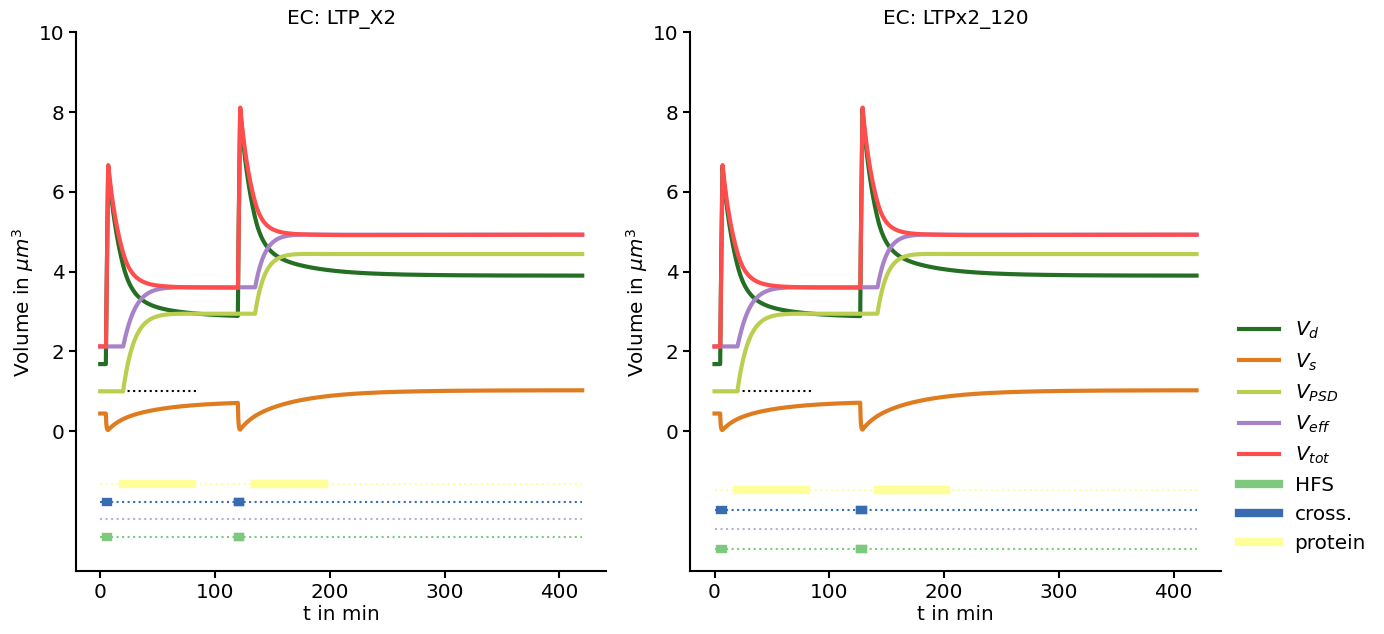

In [33]:
# Just to make sure that the last Spacing experiment corresponds exactly to the LTPX2 experiment
# This is a sanity check to make sure that the SPACING experiments were defined correctly 
# (it happened before that the definition was wrong so the results were misleading)
Sim.plot_comparison(results = [ltp2[0],spacing[-1]], n_cols = 2) 

In [34]:
# Sim.plot_results(spacing, filename="all_spacing_exp.pdf") # Here you can plot ALL of the spacing experiments in a huge plot, to see how each looks independently.